In [1]:
"""
GP emulation for Line-of-sight integrals for GNFW profile.
"""
##### Packages ###############
import numpy as np
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
import GPy

In [2]:
############################# PARAMETERS ##############################

dataDir = "./Data/" ## Data folder
modelDir = "./Models/" ## Data folder
plotsDir = "./Plots/" ## Data folder

fileIn = "LatinSq_pressure_profiles1024.npy"  ## Includes parameters + profile
nRankMax = [2, 4, 8, 16, 32][3]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

del_idx = [220, 855, 360, 705]  ## Random holdouts (not used in training, reserved for validation) 

In [3]:
######################## GP PREDICTION FUNCTIONS ###############################

def GPy_predict(para_array):
    m1p = m1.predict(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded[0]

    else:
        W_predArray, _ = GPy_predict(para_array)
        x_decoded = pca_model.inverse_transform(W_predArray)
        return x_decoded.T

In [4]:
# ################################# I/O #################################

loadfile = np.load(dataDir + fileIn)
m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))


parameter_array_all = loadfile[:, :4]
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
parameter_array.shape

nfw_all = loadfile[:, 4:]
nfw_all = np.log10(nfw_all)
nfw = np.delete(nfw_all, del_idx, axis=0)

rad = np.arange(nfw.shape[1])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Time per emulation 0.00141  s
Time per emulation 0.00116  s
Time per emulation 0.00337  s
Time per emulation 0.00315  s


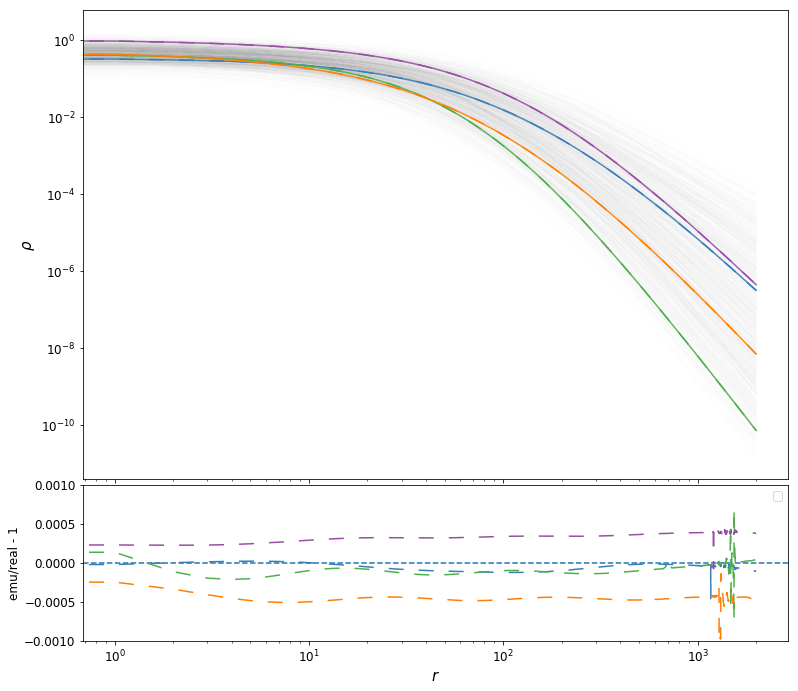

In [5]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######


# plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=12)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$\rho$', fontsize=15)

ax1.axhline(y=0, ls='dashed')
# ax1.axhline(y=-1e-6, ls='dashed')
# ax1.axhline(y=1e-6, ls='dashed')

ax1.set_xlabel(r'$r$', fontsize=15)

ax0.set_yscale('log', basey=10)
ax0.set_xscale('log', basex=10)
ax1.set_xscale('log', basex=10)

ax1.set_ylabel(r'emu/real - 1')
ax1.set_ylim(-1e-3, 1e-3)


ax0.plot(rad, 10 ** nfw.T, alpha=0.005, color='k')

color_id = 0
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    x_decoded_new = Emu(parameter_array_all[x_id])

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')

    ax0.plot(rad, 10 ** x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

    x_test = nfw_all[x_id]
    ax0.plot(rad, 10 ** x_test, alpha=0.9, label='real', color=plt.cm.Set1(color_id))

    ax1.plot(rad, (10 ** x_decoded_new) / (10 ** x_test) - 1, ls='--', dashes=(10, 10), color=plt.cm.Set1(color_id))

    plt.legend()


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'NFWemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [6]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


In [7]:
Emu(np.array([1, 1, 1, 1]) )

array([1.15949583, 0.99901641, 0.95894785, ..., 0.081069  , 0.08101903,
       0.08097025])